(PosixPath('data/public/videos/2_i_setup_bridge_mp.mp4'), PosixPath('data/public/masks/2_i_setup_mp.png'), PosixPath('data/public/backgrounds/setup.png'))


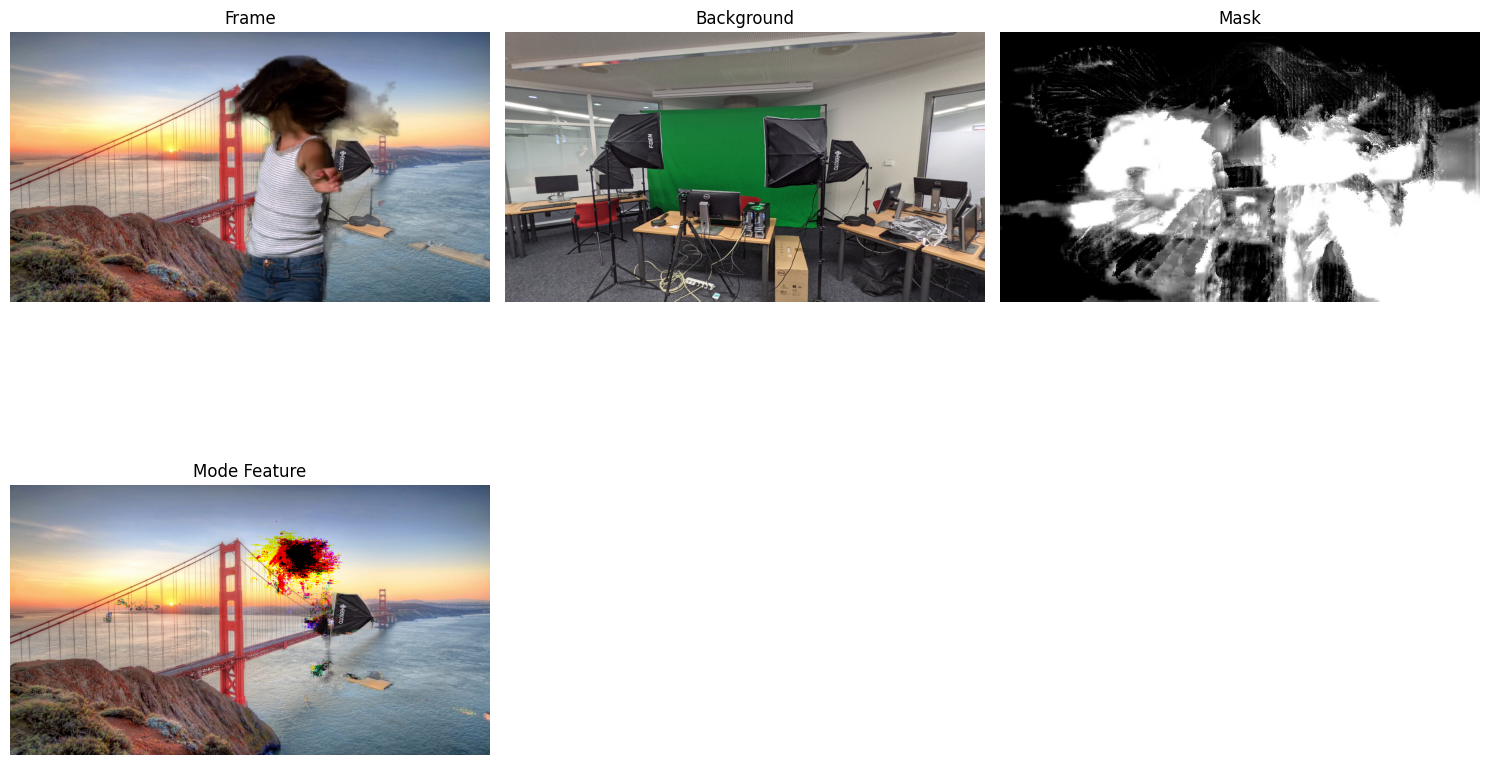

In [12]:
from json import load
from scipy.ndimage import median_filter
from matplotlib.pylab import f
import matplotlib.pyplot as plt
from truesight.masks import create_continuous_similarity_mask
from truesight.util import load_video, load_background, load_mask, load_triplets, show_image, show_images
from truesight.features import mode_feature
import numpy as np
# import logarithm


triplets = load_triplets("data/public/backgrounds", "data/public/videos","data/public/masks")
sample = triplets[30]
print(sample)
video = np.array(load_video(sample[0]))
background = load_background(sample[2])
mask = load_mask(sample[1])
mask_f = mask.astype(float) / 255.0
frame_idx = 250
frame = video[frame_idx]

video_mode = mode_feature(video).numpy()

show_images(
    [frame, background, mask, video_mode],
    titles=["Frame", "Background", "Mask", "Mode Feature"],
)

### Higher Saturation

Testing LAB Color Space

In [13]:
import cv2
import numpy as np

def bgr_to_lab(img_bgr: np.ndarray) -> np.ndarray:
    """
    Convert a BGR image to CIE L*a*b* color space.
    Args:
        img_bgr: H×W×3 uint8 BGR image
    Returns:
        img_lab: H×W×3 float32 LAB image,
                 L in [0,100], a and b in approximately [-128,127]
    """
    # 1) OpenCV returns 8-bit LAB with L∈[0,255], a,b∈[0,255]
    lab_8u = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    lab = lab_8u.astype(np.float32)
    # 2) Scale L channel to [0,100]
    lab[..., 0] = lab[..., 0] * (100.0 / 255.0)
    # 3) Shift a,b channels to center around 0
    lab[..., 1:] = lab[..., 1:] - 128.0
    return lab

def lab_to_bgr(img_lab: np.ndarray) -> np.ndarray:
    """
    Convert a CIE L*a*b* image back to BGR.
    Args:
        img_lab: H×W×3 float32 LAB image,
                 L in [0,100], a and b in approximately [-128,127]
    Returns:
        img_bgr: H×W×3 uint8 BGR image
    """
    lab = img_lab.copy().astype(np.float32)
    # 1) undo a,b shift
    lab[..., 1:] = lab[..., 1:] + 128.0
    # 2) scale L back to [0,255]
    lab[..., 0] = lab[..., 0] * (255.0 / 100.0)
    # 3) clip and convert to uint8
    lab_8u = np.clip(lab, 0, 255).astype(np.uint8)
    # 4) OpenCV color conversion
    bgr = cv2.cvtColor(lab_8u, cv2.COLOR_LAB2BGR)
    return bgr


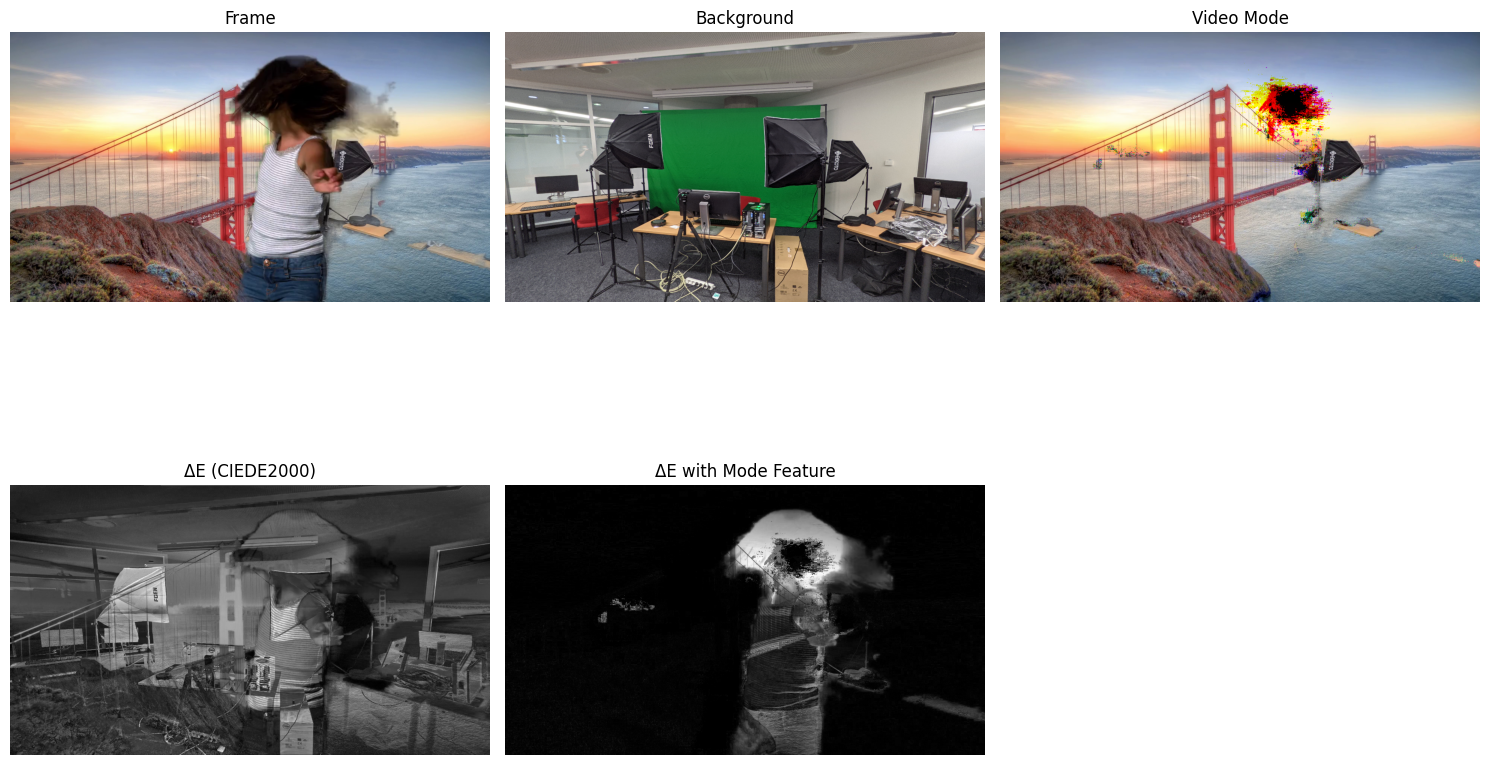

In [14]:
from truesight.util import delta_e_image
dE = delta_e_image(frame, background)  # shape (H, W)

dE_2 = delta_e_image(frame, video_mode)
show_images(
    [frame, background, video_mode, dE, dE_2],
    titles=["Frame", "Background","Video Mode", "ΔE (CIEDE2000)", "ΔE with Mode Feature"],
)

Scaled ΔE min: 0.475680459168 max: 1.0 mean: 0.853833601399


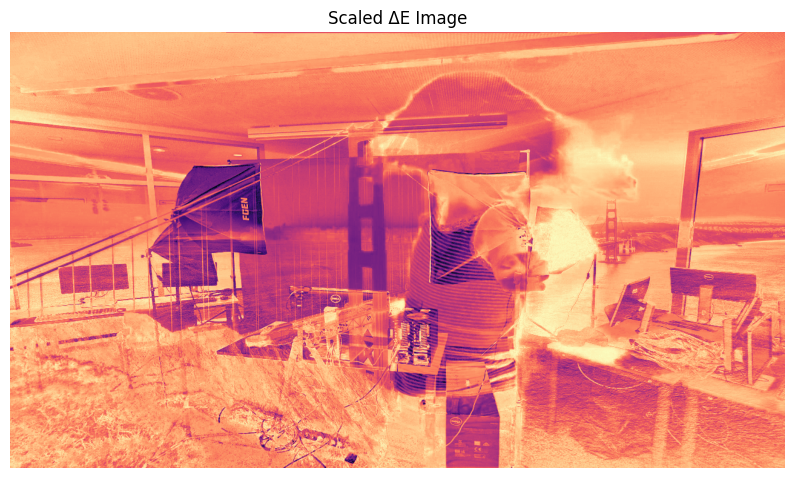

In [15]:
# theoretical maximum ΔE (CIE76 space) → ≃370.4
MAX_DE = np.sqrt(100.0**2 + 255.0**2 + 255.0**2)

def scale_delta_e(
    dE: np.ndarray
) -> np.ndarray:
    """
    Linearly map ΔE in [0…MAX_DE] → [-1…1].
    Values above MAX_DE will be clipped at ±1.
    """
    # normalize to [0,1]
    norm = np.clip(dE / MAX_DE, 0.0, 1.0)
    # shift to [−1,1]
    # return norm * 2.0 - 1.0 # output: -1 similar, 1 dissimilar
    return 1.0 - 2.0 * norm   # output: 1 similar, -1 dissimilar


dE = delta_e_image(frame, background)
scaled_dE = scale_delta_e(dE) 
# scaled_dE = scaled_dE > 0.6
print("Scaled ΔE min:", scaled_dE.min(), "max:", scaled_dE.max(), "mean:", scaled_dE.mean())
show_image(scaled_dE, title="Scaled ΔE Image", cmap='magma')

Scaled ΔE Mode min: 0.469942030682 max: 1.0 mean: 0.963202134894


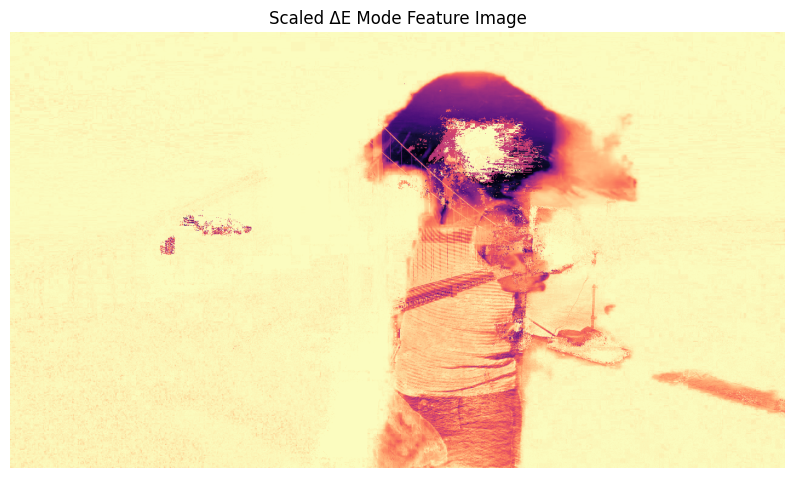

In [16]:
dE_mode = delta_e_image(frame, video_mode)
scaled_dE_mode = scale_delta_e(dE_mode)
print("Scaled ΔE Mode min:", scaled_dE_mode.min(), "max:", scaled_dE_mode.max(), "mean:", scaled_dE_mode.mean())
show_image(scaled_dE_mode, title="Scaled ΔE Mode Feature Image", cmap='magma')

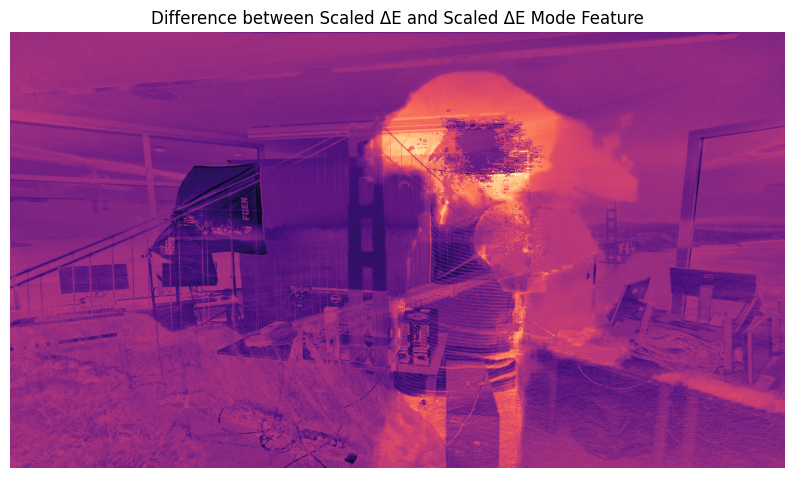

In [17]:
# calculate difference between scaled ΔE and scaled ΔE mode
diff = scaled_dE - scaled_dE_mode
show_image(diff, title="Difference between Scaled ΔE and Scaled ΔE Mode Feature", cmap='magma')

In [18]:
import cv2
import numpy as np
from skimage.color import deltaE_ciede2000, rgb2lab

def enhanced_color_distance_mask(frame, true_background, virtual_background, ta=10.0, tr=5.0, erosion_kernel_size=3):
    """
    Create an enhanced similarity mask using CIEDE2000 color distance with dual thresholds
    
    Args:
        frame: Current video frame (BGR)
        true_background: Ground truth background image (BGR)
        virtual_background: Virtual background image (BGR) 
        ta: Threshold for adding pixels (distance to virtual background)
        tr: Threshold for removing pixels (distance to virtual background)
        erosion_kernel_size: Size of erosion kernel for boundary refinement
    
    Returns:
        Enhanced binary mask indicating leaked pixels
    """
    
    # Convert BGR to RGB for scikit-image
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    virtual_bg_rgb = cv2.cvtColor(virtual_background, cv2.COLOR_BGR2RGB)
    true_bg_rgb = cv2.cvtColor(true_background, cv2.COLOR_BGR2RGB)
    
    # Convert to Lab color space
    frame_lab = rgb2lab(frame_rgb)
    virtual_bg_lab = rgb2lab(virtual_bg_rgb)
    true_bg_lab = rgb2lab(true_bg_rgb)
    
    # Step 1: Initial erosion to handle boundary effects
    initial_mask = create_initial_similarity_mask(frame_lab, true_bg_lab)
    kernel = np.ones((erosion_kernel_size, erosion_kernel_size), np.uint8)
    eroded_mask = cv2.erode(initial_mask.astype(np.uint8), kernel, iterations=1)
    
    # Step 2: Calculate CIEDE2000 distances to virtual background (vectorized!)
    virtual_bg_distances = deltaE_ciede2000(frame_lab, virtual_bg_lab)
    
    # Step 3: Apply dual thresholds
    # Add pixels with high distance to virtual background (likely not virtual background)
    add_mask = virtual_bg_distances > ta
    
    # Remove pixels with low distance to virtual background (likely virtual background)
    remove_mask = virtual_bg_distances < tr
    
    # Step 4: Combine masks according to the formula: Mr = Me + DIST(Me, V̄) > ta - DIST(Me, V̄) < tr
    refined_mask = eroded_mask.astype(bool)
    refined_mask = np.logical_or(refined_mask, add_mask)
    refined_mask = np.logical_and(refined_mask, ~remove_mask)
    
    return refined_mask.astype(np.uint8) * 255

def create_initial_similarity_mask(frame_lab, true_bg_lab, threshold=10.0):
    """Create initial similarity mask using CIEDE2000 distance"""
    # Use CIEDE2000 for initial mask too
    distances = deltaE_ciede2000(frame_lab, true_bg_lab)
    return (distances < threshold).astype(np.uint8) * 255


from skimage.color import deltaE_ciede2000, rgb2lab
import cv2
import numpy as np

def ciede2000_leak_detection(frame, true_background, virtual_background=None, 
                           similarity_threshold=8.0, virtual_threshold_high=12.0, 
                           virtual_threshold_low=4.0):
    """
    Detect background leaks using CIEDE2000 color distance
    
    Args:
        frame: Video frame (BGR)
        true_background: True background image (BGR)
        virtual_background: Virtual background (BGR), if None will estimate
        similarity_threshold: Threshold for similarity to true background
        virtual_threshold_high: High threshold for distance to virtual background
        virtual_threshold_low: Low threshold for distance to virtual background
    """
    
    # Convert to RGB then Lab
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    true_bg_rgb = cv2.cvtColor(true_background, cv2.COLOR_BGR2RGB)
    
    frame_lab = rgb2lab(frame_rgb)
    true_bg_lab = rgb2lab(true_bg_rgb)
    
    # Calculate similarity to true background
    true_bg_distances = deltaE_ciede2000(frame_lab, true_bg_lab)
    similarity_mask = true_bg_distances < similarity_threshold
    
    # If virtual background is provided, use it for refinement
    if virtual_background is not None:
        virtual_bg_rgb = cv2.cvtColor(virtual_background, cv2.COLOR_BGR2RGB)
        virtual_bg_lab = rgb2lab(virtual_bg_rgb)
        
        # Calculate distances to virtual background
        virtual_distances = deltaE_ciede2000(frame_lab, virtual_bg_lab)
        
        # Refine mask: pixels similar to true background AND dissimilar to virtual background
        virtual_refinement = virtual_distances > virtual_threshold_high
        similarity_mask = np.logical_and(similarity_mask, virtual_refinement)
        
        # Remove pixels too similar to virtual background
        virtual_removal = virtual_distances < virtual_threshold_low
        similarity_mask = np.logical_and(similarity_mask, ~virtual_removal)
    
    return similarity_mask.astype(np.uint8) * 255


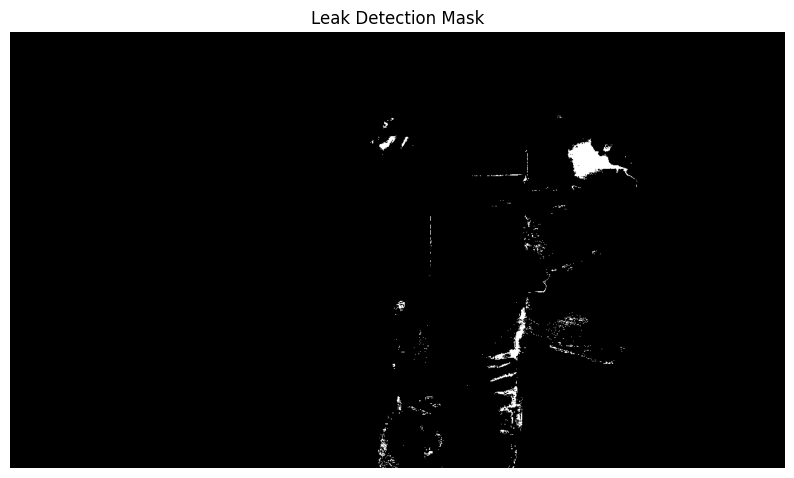

In [20]:
# Example usage with parameter optimization
def find_optimal_thresholds(frame, true_background, virtual_background, ground_truth_mask):
    """
    Helper function to find optimal thresholds by testing different values
    """
    best_score = 0
    best_params = {}
    
    # Test different threshold combinations
    for sim_thresh in [6, 8, 10, 12]:
        for virt_high in [10, 12, 15, 18]:
            for virt_low in [3, 4, 5, 6]:
                if virt_low >= virt_high:
                    continue
                    
                mask = ciede2000_leak_detection(
                    frame, true_background, virtual_background,
                    similarity_threshold=sim_thresh,
                    virtual_threshold_high=virt_high,
                    virtual_threshold_low=virt_low
                )
                
                # Calculate IoU with ground truth
                intersection = np.logical_and(mask > 0, ground_truth_mask > 0)
                union = np.logical_or(mask > 0, ground_truth_mask > 0)
                iou = np.sum(intersection) / np.sum(union)
                
                if iou > best_score:
                    best_score = iou
                    best_params = {
                        'similarity_threshold': sim_thresh,
                        'virtual_threshold_high': virt_high,
                        'virtual_threshold_low': virt_low,
                        'iou': iou
                    }
    
    return best_params

# Usage
frame = frame
true_bg = background
virtual_bg = video_mode  # Use mode feature as virtual background


# Create leak detection mask
leak_mask = ciede2000_leak_detection(frame, true_bg, virtual_bg)

# Visualize
show_image(leak_mask, title="Leak Detection Mask", cmap='gray')

In [24]:
def temporal_consistency_check(frame_sequence, true_background, window_size=5, consistency_threshold=0.7):
    """
    Check temporal consistency of potential leak pixels across frames
    
    Args:
        frame_sequence: List of consecutive frames
        true_background: Ground truth background
        window_size: Number of frames to analyze
        consistency_threshold: Minimum consistency ratio (0-1)
    """
    h, w = frame_sequence[0].shape[:2]
    consistency_mask = np.zeros((h, w), dtype=np.float32)
    
    # For each pixel, check consistency across the temporal window
    for i in range(h):
        for j in range(w):
            pixel_similarities = []
            
            for frame in frame_sequence:
                # Calculate similarity to true background for this pixel
                frame_lab = rgb2lab(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                bg_lab = rgb2lab(cv2.cvtColor(true_background, cv2.COLOR_BGR2RGB))
                
                distance = deltaE_ciede2000(
                    frame_lab[i:i+1, j:j+1], 
                    bg_lab[i:i+1, j:j+1]
                )[0, 0]
                
                # Consider pixel similar if distance is below threshold
                pixel_similarities.append(distance < 10.0)
            
            # Calculate consistency ratio
            consistency_ratio = np.mean(pixel_similarities)
            consistency_mask[i, j] = consistency_ratio
    
    # Return pixels that are consistently similar across frames
    return consistency_mask > consistency_threshold

def calculate_mask_consistency_score(frame_sequence, true_background, tau=0.5):
    """
    Calculate temporal consistency using Mask Consistency Score approach
    
    Args:
        frame_sequence: Sequence of video frames
        true_background: Ground truth background
        tau: Jaccard index threshold for consistency
    """
    frame_masks = []
    
    # Generate similarity masks for each frame
    for frame in frame_sequence:
        mask = ciede2000_leak_detection(frame, true_background)
        frame_masks.append(mask)
    
    # Calculate Jaccard indices between consecutive frames
    jaccard_indices = []
    for i in range(len(frame_masks) - 1):
        mask1 = frame_masks[i] > 0
        mask2 = frame_masks[i + 1] > 0
        
        intersection = np.logical_and(mask1, mask2)
        union = np.logical_or(mask1, mask2)
        
        if np.sum(union) > 0:
            jaccard = np.sum(intersection) / np.sum(union)
        else:
            jaccard = 1.0  # Both masks are empty
            
        jaccard_indices.append(jaccard)
    
    # Check if all frames meet the consistency threshold
    consistent = all(j >= tau for j in jaccard_indices)
    
    return consistent, np.mean(jaccard_indices)

def optical_flow_temporal_consistency(frame_sequence, true_background):
    """
    Use optical flow to track potential leak pixels across frames
    """
    consistent_leaks = np.zeros_like(frame_sequence[0][:,:,0], dtype=bool)
    
    for i in range(len(frame_sequence) - 1):
        current_frame = cv2.cvtColor(frame_sequence[i], cv2.COLOR_BGR2GRAY)
        next_frame = cv2.cvtColor(frame_sequence[i + 1], cv2.COLOR_BGR2GRAY)
        
        # Calculate optical flow
        flow = cv2.calcOpticalFlowPyrLK(current_frame, next_frame, None, None)
        
        # Get similarity masks for both frames
        current_mask = ciede2000_leak_detection(frame_sequence[i], true_background) > 0
        next_mask = ciede2000_leak_detection(frame_sequence[i + 1], true_background) > 0
        
        # Track pixels using optical flow and check consistency
        h, w = current_frame.shape
        y_coords, x_coords = np.mgrid[0:h, 0:w]
        
        # Apply flow to coordinates
        new_coords = np.stack([x_coords + flow[..., 0], y_coords + flow[..., 1]], axis=-1)
        
        # Check if tracked pixels remain consistent leaks
        for y in range(h):
            for x in range(w):
                if current_mask[y, x]:
                    new_x, new_y = new_coords[y, x]
                    if (0 <= new_x < w and 0 <= new_y < h and 
                        next_mask[int(new_y), int(new_x)]):
                        consistent_leaks[y, x] = True
    
    return consistent_leaks

def enhanced_leak_detection_with_temporal_consistency(frame_buffer, true_background, 
                                                    buffer_size=10, consistency_ratio=0.8):
    """
    Enhanced leak detection using temporal consistency
    
    Args:
        frame_buffer: Circular buffer of recent frames
        true_background: Ground truth background
        buffer_size: Number of frames to consider
        consistency_ratio: Minimum ratio of frames where pixel should be detected as leak
    """
    if len(frame_buffer) < buffer_size:
        # Not enough frames for temporal analysis, use single frame method
        return ciede2000_leak_detection(frame_buffer[-1], true_background)
    
    # Get recent frames
    recent_frames = frame_buffer[-buffer_size:]
    
    # Generate masks for each frame
    frame_masks = []
    for frame in recent_frames:
        mask = ciede2000_leak_detection(frame, true_background)
        frame_masks.append(mask > 0)
    
    # Calculate temporal consistency for each pixel
    h, w = frame_masks[0].shape
    temporal_consistency = np.zeros((h, w), dtype=np.float32)
    
    for i in range(h):
        for j in range(w):
            # Count how many frames this pixel was detected as leak
            leak_count = sum(mask[i, j] for mask in frame_masks)
            temporal_consistency[i, j] = leak_count / buffer_size
    
    # Keep only pixels that are consistently detected as leaks
    consistent_leak_mask = temporal_consistency >= consistency_ratio
    
    return consistent_leak_mask.astype(np.uint8) * 255


In [25]:
from truesight.util import bgr_to_lab
output_mask = enhanced_leak_detection_with_temporal_consistency( [bgr_to_lab(frame) for frame in video[:20]], bgr_to_lab(background), buffer_size=10, consistency_ratio=0.9 )

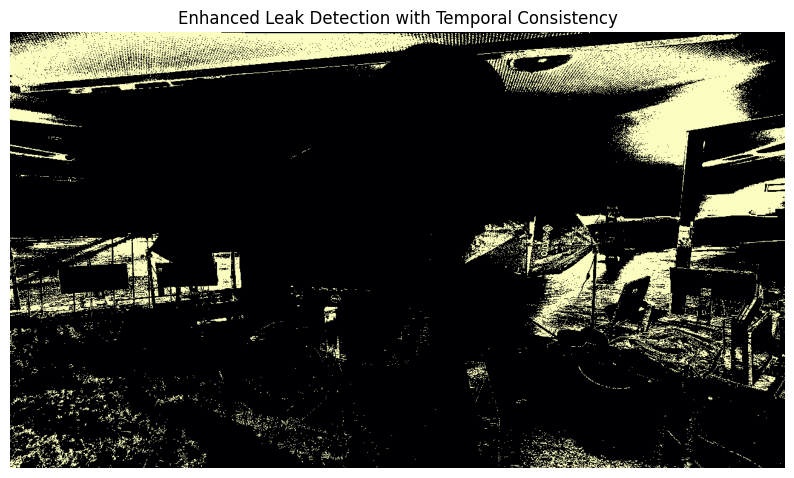

In [27]:
show_image(output_mask, title="Enhanced Leak Detection with Temporal Consistency", cmap='magma')